In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

In [3]:
aapl_df = yf.download('AAPL', start='2010-01-01', end='2024-10-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
aapl_df.to_csv('AAPL.csv')

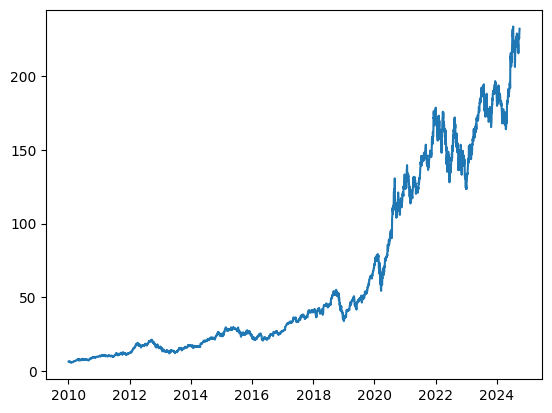

In [5]:
plt.plot(aapl_df["Close"])

In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

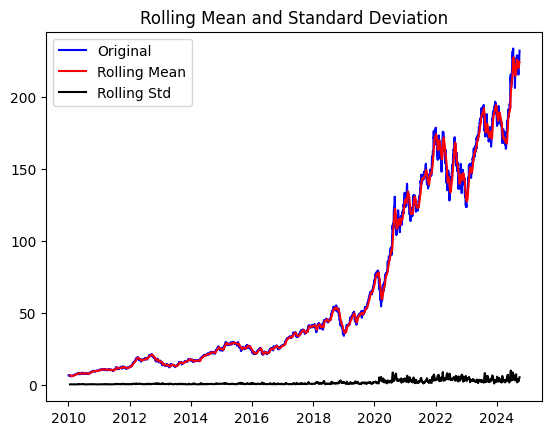

Results of dickey fuller test
Test Statistics                   1.438442
p-value                           0.997282
No. of lags used                 18.000000
Number of observations used    3691.000000
critical value (1%)              -3.432123
critical value (5%)              -2.862323
critical value (10%)             -2.567187
dtype: float64


In [7]:
test_stationarity(aapl_df["Close"])

<Axes: ylabel='Density'>

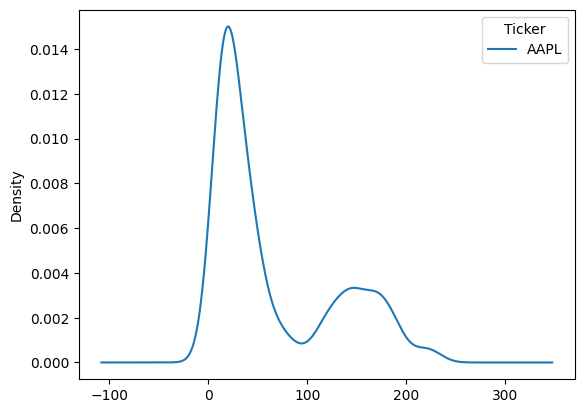

In [8]:
#Distribution of the dataset
df_close = aapl_df['Close']
df_close.plot(kind='kde')

<Figure size 640x480 with 0 Axes>

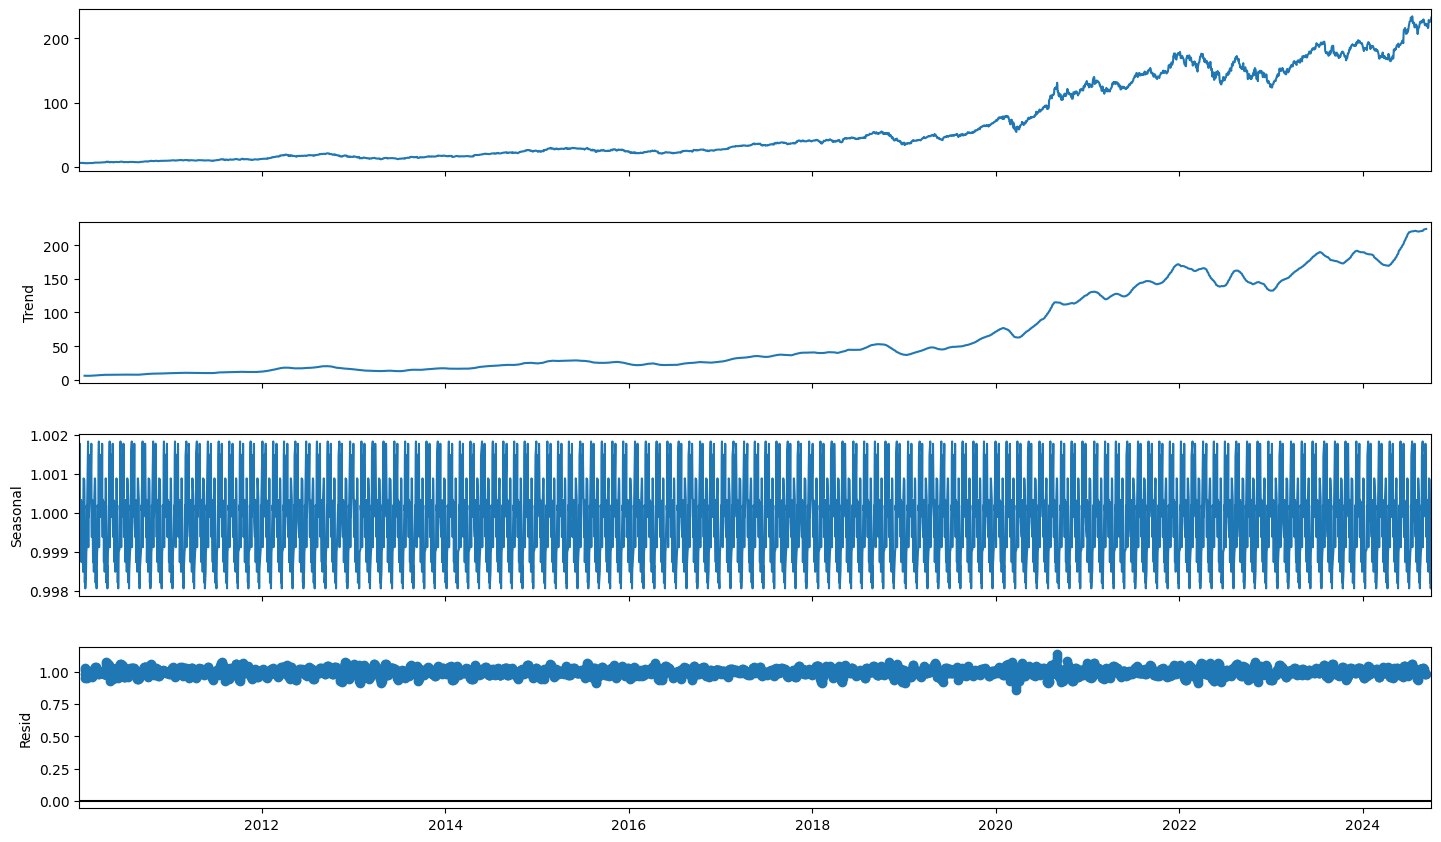

In [9]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

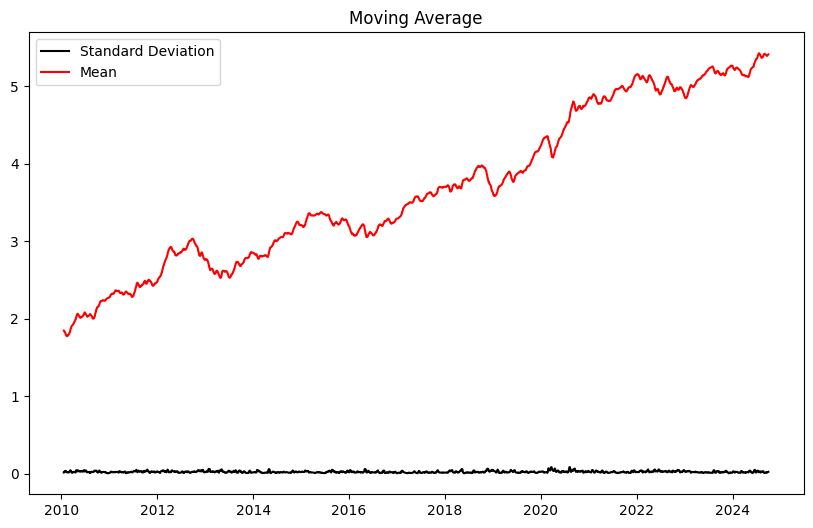

In [10]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

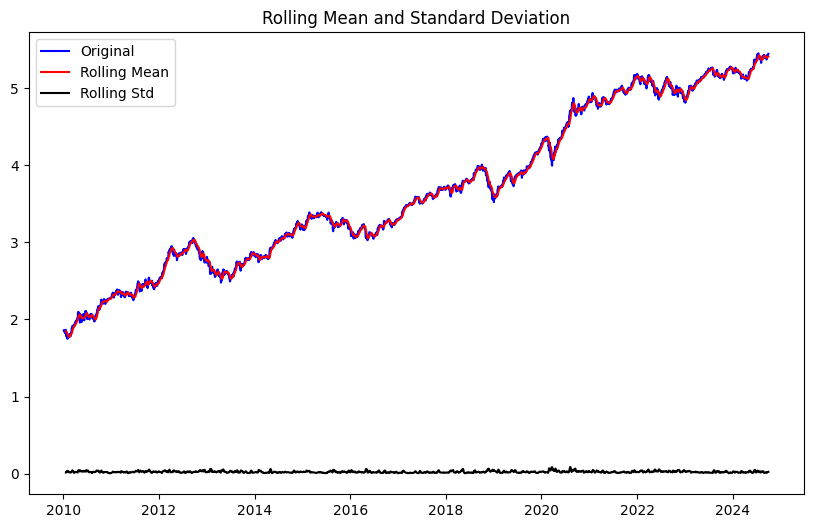

Results of dickey fuller test
Test Statistics                  -0.655487
p-value                           0.857945
No. of lags used                  9.000000
Number of observations used    3700.000000
critical value (1%)              -3.432119
critical value (5%)              -2.862321
critical value (10%)             -2.567186
dtype: float64


In [11]:
test_stationarity(df_log)

In [12]:
ts_log_diff = df_log.diff().dropna()

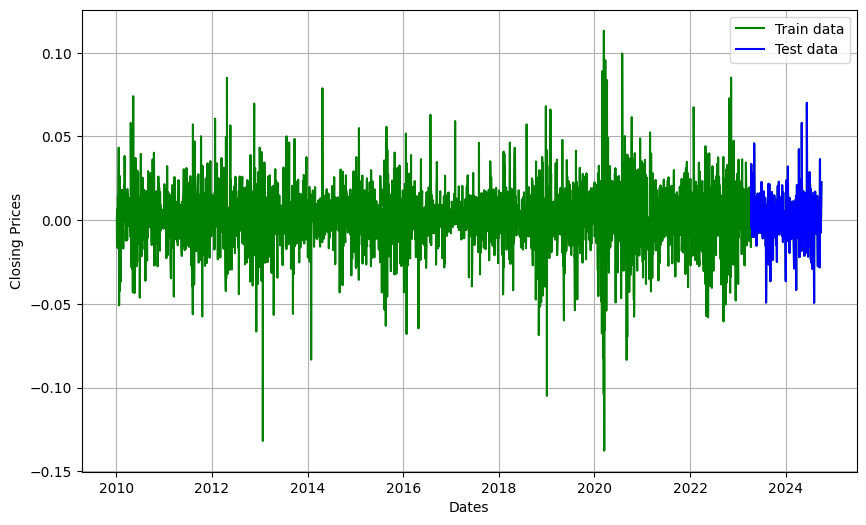

In [13]:
#split data into train and training set
train_data, test_data = ts_log_diff[3:int(len(df_log)*0.9)], ts_log_diff[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ts_log_diff, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-17308.241, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-17312.480, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-17312.426, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-17310.545, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-17310.706, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-17308.526, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-17320.927, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-17315.794, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-17318.932, Time=0.63 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-17318.978, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-17320.910, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-17316.927, Time=0.59 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.794 seconds
                               SARIMAX Results                  

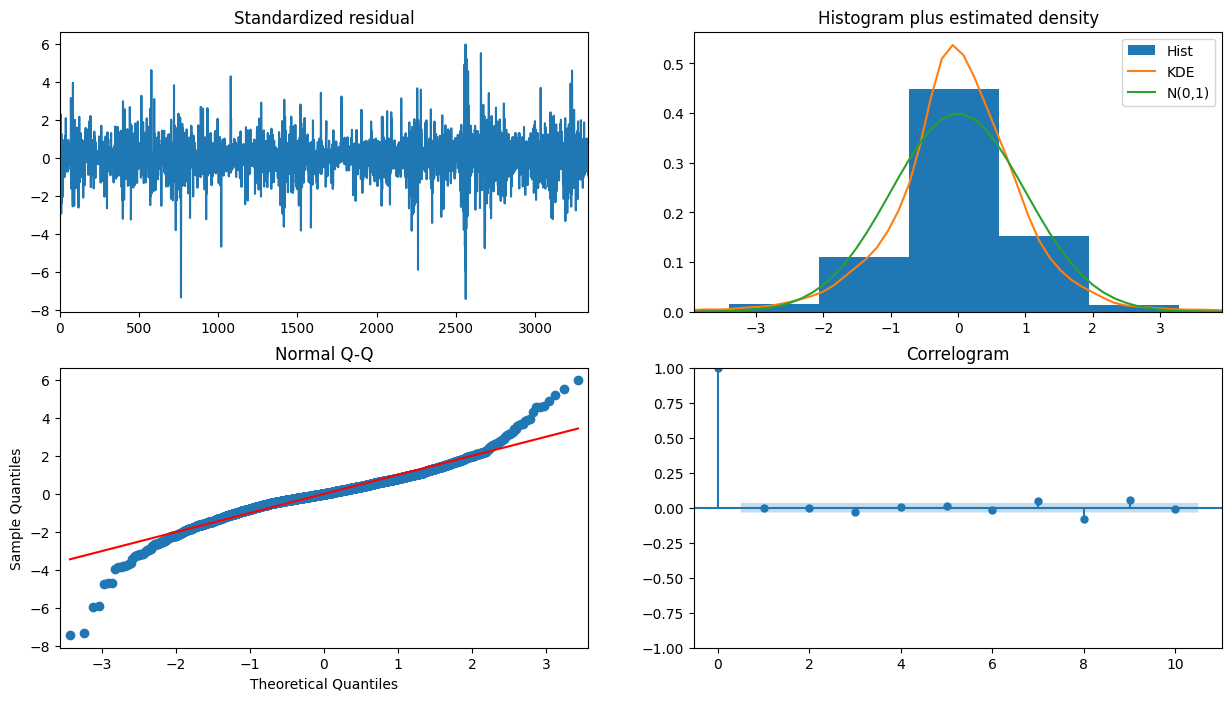

In [14]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [15]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,0,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 3336
Model:                 ARIMA(1, 0, 0)   Log Likelihood                8663.463
Date:                Sun, 08 Jun 2025   AIC                         -17320.927
Time:                        14:29:05   BIC                         -17302.589
Sample:                             0   HQIC                        -17314.366
                               - 3336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.186      0.001       0.000       0.002
ar.L1         -0.0462      0.012     -3.981      0.000      -0.069      -0.023
sigma2         0.0003    4.5e-06     72.256      0.0

c:\Users\Pam\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Pam\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Pam\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [16]:
len(test_data)

370

c:\Users\Pam\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


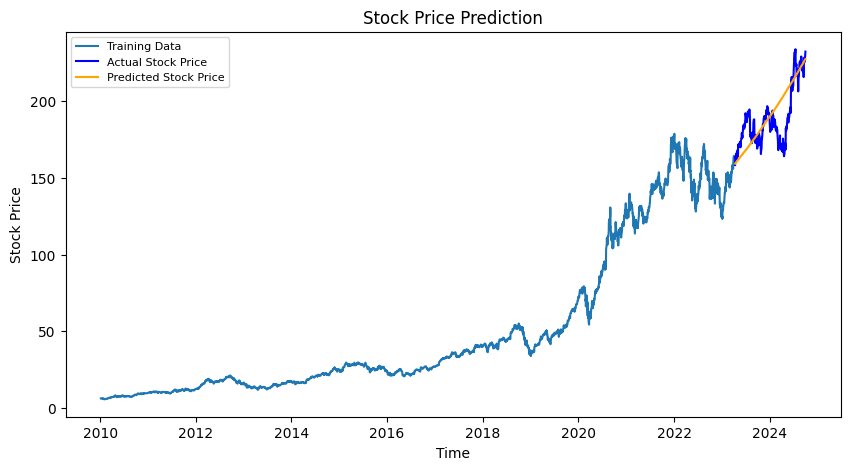

In [17]:
# Forecast
fc = fitted.forecast(370, alpha=0.05)  # 95% conf

# Step 1: Get the last log value from the original log-transformed series BEFORE test starts
last_log_value = df_log.iloc[int(len(df_log)*0.9)]  # one step BEFORE the test start

# Step 2: Cumulative sum to undo differencing
fc_log = fc.cumsum() + last_log_value.values

# Step 3: Exponentiate to undo log transform
fc_original = np.exp(fc_log)

# Step 4: For comparison, slice the original closing prices for the test period
actual_test_prices = df_close.iloc[int(len(df_log)*0.9)+1:]  # +1 due to differencing

# Step 5: Create aligned DataFrame for plotting
fc_original = pd.Series(list(fc_original), index=actual_test_prices.index)

# Make as pandas series
# fc_series = pd.Series(fc).reindex(test_data.index)
# fc_df = pd.DataFrame(list(fc), index=pd.Index(test_data.index.values))
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_close[3:int(len(df_log)*0.9)], label='Training Data')
plt.plot(actual_test_prices, color = 'blue', label='Actual Stock Price')
plt.plot(fc_original, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
                #  color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

c:\Users\Pam\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


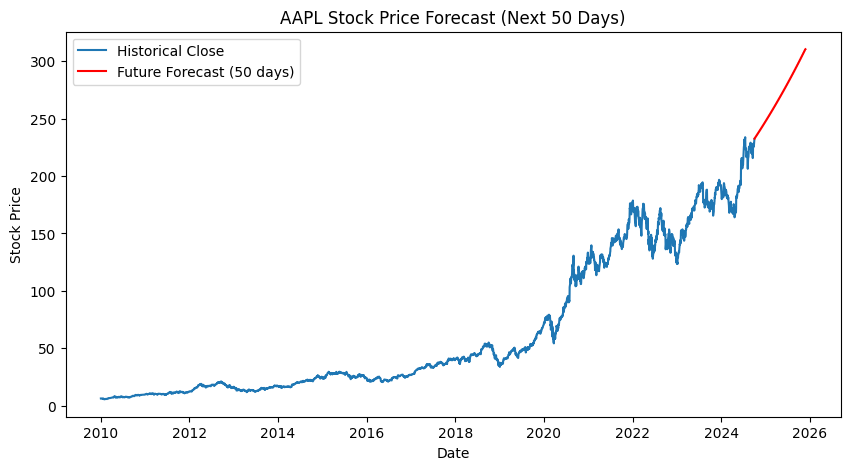

In [18]:
# Forecast 50 days into the future
future_steps = 300
future_fc = fitted.forecast(future_steps, alpha=0.05)

# Get the last log value as a scalar
future_start_log = df_log.iloc[-1, 0]

# Inverse differencing: cumulative sum + last log value
future_fc_log = future_fc.cumsum() + future_start_log

# Inverse log: exponentiate to get back to original scale
future_fc_original = np.exp(future_fc_log)

# Create future date index
last_date = df_log.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='B')

# Make as pandas Series for plotting
future_fc_original = pd.Series(future_fc_original.values, index=future_dates)

# Plot the forecast
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_close.index, df_close['AAPL'], label='Historical Close')
plt.plot(future_fc_original.index, future_fc_original.values, color='red', label='Future Forecast (50 days)')
plt.title('AAPL Stock Price Forecast (Next 50 Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [21]:
future_df = yf.download("AAPL", start=future_dates[0], end=future_dates[-1])

[*********************100%***********************]  1 of 1 completed


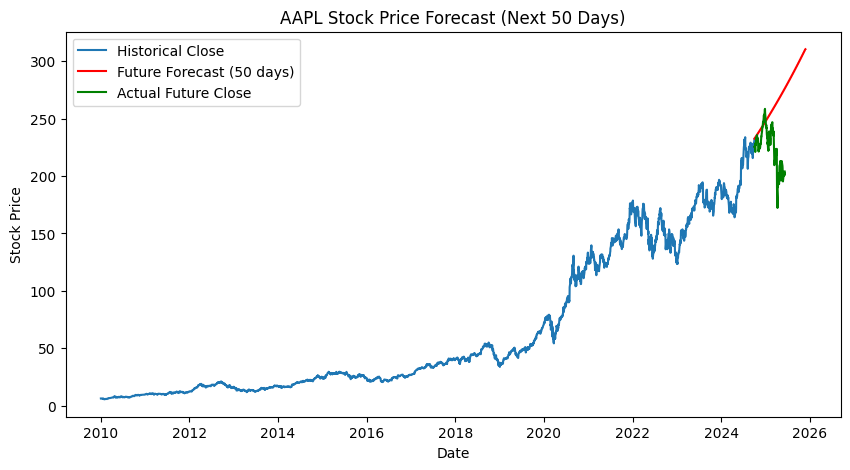

In [22]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_close.index, df_close['AAPL'], label='Historical Close')
plt.plot(future_fc_original.index, future_fc_original.values, color='red', label='Future Forecast (50 days)')
plt.plot(future_df.index, future_df['Close'], color='green', label='Actual Future Close')
plt.title('AAPL Stock Price Forecast (Next 50 Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()